# Evaluate Improved Earring Label

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


## Settings

In [3]:
SAVE_NAME = 'vae.fixed_earring'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'

TEST_SIZE = 1000
EPOCHS = 200
LR = 1e-04
BATCH_SIZE = 32
LABELS_FILE = '../scripts/pallets_labels.json'


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
logger = L.init_logger(notebook=True)


## Load Environment

In [6]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../scripts/onehot_ds.pt')

dataset = torch.load('../scripts/onehot_ds.pt')

In [7]:
num_labels = len(dataset._labels[0])

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)



# The Model

This model builds off the VAE using in the previous notebook with a final call to gumbel-softmax, allow backprop to nudge the output of the decoder into place

In [8]:
# Train Model

latent_dims = 32
model = M.vae.LabeledVAE(222, (64, 32), latent_dims, num_labels)

criterion = M.vae.Loss()


In [9]:
logger.info("starting model training")

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | starting model training
INFO | model: pallets.models.vae.LabeledVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.0001
INFO | epochs: 200
INFO | epoch 1 (  0%) loss: 511269.343750
INFO | epoch 1 ( 35%) loss: 185493.360642
INFO | epoch 1 ( 70%) loss: 97307.175176
INFO | epoch 1 (100%) loss: 71299.689519
INFO | epoch 1 (test) loss: 6258.131599
INFO | epoch 2 (  0%) loss: 6312.841797
INFO | epoch 2 ( 35%) loss: 6069.685876
INFO | epoch 2 ( 70%) loss: 5677.711195
INFO | epoch 2 (100%) loss: 5323.010133
INFO | epoch 2 (test) loss: 4115.539162
INFO | epoch 3 (  0%) loss: 4104.662598
INFO | epoch 3 ( 35%) loss: 4078.294999
INFO | epoch 3 ( 70%) loss: 3969.753986
INFO | epoch 3 (100%) loss: 3886.063596
INFO | epoch 3 (test) loss: 3561.567863
INFO | epoch 4 (  0%) loss: 3923.879883
INFO | epoch 4 ( 35%) loss: 3611.518724
INFO | epoch 4 ( 70%) loss: 3584.862511
INFO | epoch 4 (100%) loss: 3544.415321
INFO | epoch 4 (test) loss: 3353.421638
INFO | epoch 5 (  0%) loss: 3349

## Test Model

In [10]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)


In [11]:
import json
ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

_, test_labels = next(iter(train_loader))
features = test_labels[2]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['male', 'frontBeard', 'mohawk', 'hornedRimGlasses']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


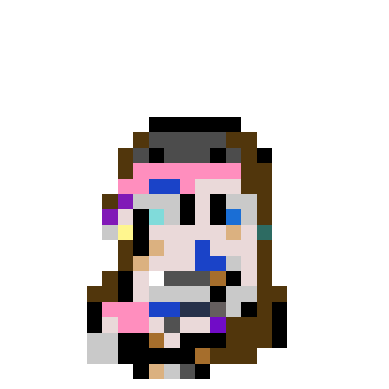

In [12]:
# Totally Random

z = torch.randn(1, latent_dims + num_labels).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


In [19]:
import json
ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

_, test_labels = next(iter(train_loader))
features = test_labels[2]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['female', 'halfShaved', 'goldChain', 'clownEyesBlue']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


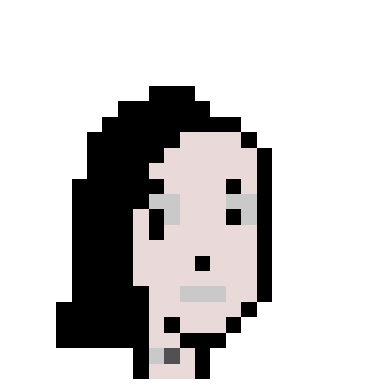

In [20]:
# Generate new image

# Random data for image side
z = torch.randn(1, latent_dims).to(device)

# Concat image with actual feature labels from dataset
z = torch.concat([z, features.unsqueeze(0)], dim=1)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)
decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Graph Losses

In [16]:
train_losses

[142599.37903784352,
 10646.02026540337,
 7772.12719293689,
 7088.83064172623,
 6750.371323172928,
 6529.096838119182,
 6370.465379214456,
 6221.9743617713875,
 6082.395477511359,
 5943.639921580646,
 5820.566607969027,
 5699.253414938636,
 5575.793656153036,
 5428.4600899337875,
 5272.29076325978,
 5105.761314013325,
 4950.641965176197,
 4823.440010666001,
 4715.185239101978,
 4585.438698626579,
 4421.257630693151,
 4252.498008782137,
 4082.899654307264,
 3903.581687548482,
 3706.41367464539,
 3423.701187458444,
 3199.796896210799,
 3015.9435370695505,
 2862.1875469667693,
 2738.146135262564,
 2625.3900462481993,
 2515.4929487079594,
 2415.679351373767,
 2296.0372489766874,
 2200.7533751142787,
 2127.387877985095,
 2071.9276296196253,
 2021.7922962810976,
 1981.8566798216907,
 1943.2547282766789,
 1909.3486043510707,
 1875.271747670275,
 1842.5847518596242,
 1801.0176663229652,
 1755.1258760276417,
 1714.4796643629143,
 1682.3551931178315,
 1656.0663669667344,
 1631.044030480351,
 161

In [17]:
test_losses

[12516.263198852539,
 8231.078323364258,
 7123.135726928711,
 6706.843276977539,
 6439.489639282227,
 6249.4246253967285,
 6122.708053588867,
 5975.996120452881,
 5844.875080108643,
 5712.721462249756,
 5596.719951629639,
 5470.519496917725,
 5336.953342437744,
 5201.364604949951,
 5027.458183288574,
 4869.4260177612305,
 4721.750011444092,
 4608.1118087768555,
 4531.41329574585,
 4375.020645141602,
 4221.682422637939,
 4047.9514770507812,
 3871.8596363067627,
 3696.067897796631,
 3452.771469116211,
 3192.5819396972656,
 3038.0947456359863,
 2828.2884426116943,
 2689.794351577759,
 2566.1028022766113,
 2476.8022327423096,
 2366.6078214645386,
 2272.7529163360596,
 2160.116424560547,
 2089.675075531006,
 2026.0931758880615,
 1974.3805599212646,
 1932.0810565948486,
 1895.367820739746,
 1852.9730167388916,
 1823.894567489624,
 1794.3724899291992,
 1755.4467487335205,
 1715.9776315689087,
 1698.8990049362183,
 1636.192470550537,
 1610.611008644104,
 1584.579041481018,
 1562.7725944519043,

<function matplotlib.pyplot.show(close=None, block=None)>

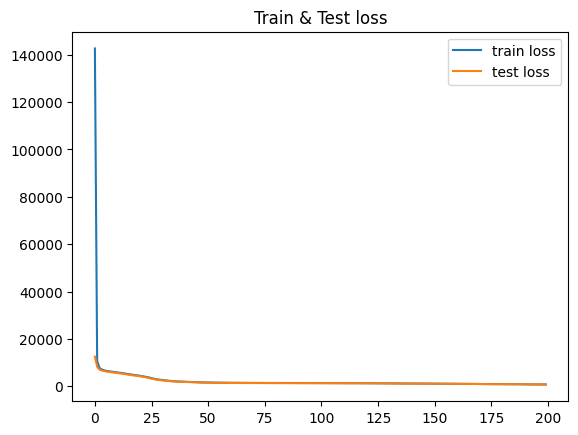

In [18]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
